In [1]:
!pip install --quiet torch scikit-learn pandas numpy nltk lime tqdm


  DEPRECATION: Building 'lime' using the legacy setup.py bdist_wheel mechanism, which will be removed in a future version. pip 25.3 will enforce this behaviour change. A possible replacement is to use the standardized build interface by setting the `--use-pep517` option, (possibly combined with `--no-build-isolation`), or adding a `pyproject.toml` file to the source tree of 'lime'. Discussion can be found at https://github.com/pypa/pip/issues/6334


In [2]:
import os
import re
import math
import numpy as np
import pandas as pd
from tqdm import tqdm
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset

from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

from lime.lime_text import LimeTextExplainer


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\krish'\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
 
DATA_FILE = "cyberbullying_tweets.csv"
TEXT_COL = "tweet_text"
LABEL_COL = "cyberbullying_type"

# GloVe file path (download and extract glove.6B.300d.txt)
GLOVE_FILE = "glove.6B.300d.txt"

# PCA target (paper uses 9000). If your machine can't handle it, change to lower (e.g., 300, 1000).
PCA_N_COMPONENTS = 9000

# Training hyperparameters
BATCH_SIZE = 64
NUM_EPOCHS = 10
LR = 1e-4
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print("Device:", DEVICE)


Device: cpu


In [4]:
assert os.path.exists(DATA_FILE), f"Dataset file not found: {DATA_FILE}"

# Load dataset first, then validate and encode labels
df = pd.read_csv(DATA_FILE)
print("Loaded dataset:", df.shape)
if TEXT_COL not in df.columns or LABEL_COL not in df.columns:
    raise KeyError(f"Expected columns '{TEXT_COL}' and '{LABEL_COL}' in {DATA_FILE}. Found: {list(df.columns)}")
df = df[[TEXT_COL, LABEL_COL]].dropna().reset_index(drop=True)
print("After dropping NA:", df.shape)

le = LabelEncoder()
df[LABEL_COL] = le.fit_transform(df[LABEL_COL])
print("Label classes:", list(le.classes_))


Loaded dataset: (47692, 2)
After dropping NA: (47692, 2)
Label classes: ['age', 'ethnicity', 'gender', 'not_cyberbullying', 'other_cyberbullying', 'religion']


In [5]:
stop = set(stopwords.words('english'))
def clean_text(t):
    t = str(t)
    t = re.sub(r"http\S+|www\.\S+", "", t)
    t = re.sub(r"@\w+|#\w+", "", t)
    t = re.sub(r"[^a-zA-Z\s]", " ", t)
    t = t.lower()
    t = " ".join([w for w in t.split() if w and w not in stop])
    return t

df['clean_text'] = df[TEXT_COL].apply(clean_text)
print("Sample cleaned text:")
print(df['clean_text'].head(3).to_list())
df = df[df['clean_text'].str.strip() != ""].reset_index(drop=True)
print("After removing empty tweets:", df.shape)


Sample cleaned text:
['words food crapilicious', 'white', 'classy whore red velvet cupcakes']
After removing empty tweets: (47199, 3)


In [6]:
assert os.path.exists(GLOVE_FILE), f"GloVe file not found: {GLOVE_FILE}. Download and extract glove.6B.300d.txt."

embeddings_index = {}
with open(GLOVE_FILE, 'r', encoding='utf8') as f:
    for line in tqdm(f, desc="Loading GloVe"):
        parts = line.rstrip().split(" ")
        word = parts[0]
        vec = np.asarray(parts[1:], dtype=np.float32)
        embeddings_index[word] = vec
print("Loaded GloVe vectors:", len(embeddings_index))


Loading GloVe: 400000it [00:21, 19017.15it/s]

Loaded GloVe vectors: 400000


In [7]:
MAX_TOKENS = 30
EMBED_DIM = 300

def get_glove_vector_sequence(text):
    words = text.split()
    vecs = []
    for w in words[:MAX_TOKENS]:
        vecs.append(embeddings_index.get(w, np.zeros(EMBED_DIM)))
    # pad if tweet has fewer than 30 tokens
    while len(vecs) < MAX_TOKENS:
        vecs.append(np.zeros(EMBED_DIM))
    return np.array(vecs).flatten()  # 30 × 300 = 9000 features

print("Generating 9000D tweet embeddings...")
X_glove = np.vstack([get_glove_vector_sequence(t) for t in tqdm(df['clean_text'])])
print("✅ X_glove shape:", X_glove.shape)


Generating 9000D tweet embeddings...


100%|██████████| 47199/47199 [00:04<00:00, 10147.89it/s]


✅ X_glove shape: (47199, 9000)


In [8]:
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA

# 1️⃣ Split first (80:20, stratified)
X_train_glove, X_test_glove, y_train, y_test = train_test_split(
    X_glove, df[LABEL_COL].values,
    test_size=0.2, random_state=42, stratify=df[LABEL_COL].values
)

# 2️⃣ Apply PCA on training data only (auto-adjust if fewer features)
max_possible = X_train_glove.shape[1]
n_comp = min(PCA_N_COMPONENTS, max_possible)

print(f"Running PCA with n_components={n_comp} on training data ...")
try:
    pca = PCA(n_components=n_comp, random_state=42)
    X_train = pca.fit_transform(X_train_glove)
    X_test  = pca.transform(X_test_glove)
    print("✅ PCA done. Train shape:", X_train.shape, "| Test shape:", X_test.shape)
    print("Explained variance ratio sum:", np.sum(pca.explained_variance_ratio_))

    if n_comp < PCA_N_COMPONENTS:
        print(f"⚠️ Note: Requested {PCA_N_COMPONENTS} components, but only {max_possible} available "
              f"(input feature dimension). Using {n_comp}.")
except Exception as e:
    print("❌ PCA failed:", str(e))
    fallback = max_possible
    print(f"Falling back to PCA n_components={fallback}")
    pca = PCA(n_components=fallback, random_state=42)
    X_train = pca.fit_transform(X_train_glove)
    X_test  = pca.transform(X_test_glove)
    print("✅ PCA done (fallback). Train shape:", X_train.shape, "| Test shape:", X_test.shape)
    print("Explained variance ratio sum:", np.sum(pca.explained_variance_ratio_))


Running PCA with n_components=9000 on training data ...
✅ PCA done. Train shape: (37759, 9000) | Test shape: (9440, 9000)
Explained variance ratio sum: 1.0


In [9]:
from sklearn.preprocessing import LabelEncoder
import torch

# 1️⃣ Encode labels before split
le = LabelEncoder()
y_all = le.fit_transform(df[LABEL_COL].values)
classes = le.classes_
print("Classes:", classes, "| n_classes:", len(classes))

# 2️⃣ Reuse the same stratified split logic from PCA cell
# (But with encoded numeric labels)
from sklearn.model_selection import train_test_split
y_train_np, y_test_np = train_test_split(
    y_all, test_size=0.2, random_state=42, stratify=y_all
)

# 3️⃣ Convert to torch tensors
X_train_t = torch.tensor(X_train, dtype=torch.float32)
X_test_t  = torch.tensor(X_test, dtype=torch.float32)
y_train_t = torch.tensor(y_train_np, dtype=torch.long)
y_test_t  = torch.tensor(y_test_np, dtype=torch.long)

print("✅ Train/Test tensor shapes:")
print("   X_train:", X_train_t.shape)
print("   X_test :", X_test_t.shape)
print("   y_train:", y_train_t.shape, "dtype:", y_train_t.dtype)
print("   y_test :", y_test_t.shape, "dtype:", y_test_t.dtype)


Classes: [0 1 2 3 4 5] | n_classes: 6


✅ Train/Test tensor shapes:
   X_train: torch.Size([37759, 9000])
   X_test : torch.Size([9440, 9000])
   y_train: torch.Size([37759]) dtype: torch.int64
   y_test : torch.Size([9440]) dtype: torch.int64


In [10]:
import torch
import torch.nn as nn

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Paper architecture constants
D_MODEL = 300           # same as GloVe embedding size
SEQ_LEN = 9000 // D_MODEL  # 30 tokens
N_HEADS = 6             # ✅ divisible by 300
DROPOUT = 0.3

class RoBERTaNetFull(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        
        # Block 1
        self.mha1 = nn.MultiheadAttention(embed_dim=D_MODEL, num_heads=N_HEADS, batch_first=True)
        self.ff1  = nn.Sequential(
            nn.Linear(D_MODEL, D_MODEL * 2),
            nn.ReLU(),
            nn.Dropout(DROPOUT),
            nn.Linear(D_MODEL * 2, D_MODEL)
        )
        self.norm1 = nn.LayerNorm(D_MODEL)
        self.norm2 = nn.LayerNorm(D_MODEL)

        # Block 2
        self.mha2 = nn.MultiheadAttention(embed_dim=D_MODEL, num_heads=N_HEADS, batch_first=True)
        self.ff2  = nn.Sequential(
            nn.Linear(D_MODEL, D_MODEL * 2),
            nn.ReLU(),
            nn.Dropout(DROPOUT),
            nn.Linear(D_MODEL * 2, D_MODEL)
        )
        self.norm3 = nn.LayerNorm(D_MODEL)
        self.norm4 = nn.LayerNorm(D_MODEL)

        # Classifier head
        self.classifier = nn.Sequential(
            nn.Linear(D_MODEL, D_MODEL // 2),
            nn.ReLU(),
            nn.Dropout(DROPOUT),
            nn.Linear(D_MODEL // 2, num_classes)
        )

    def forward(self, x_flat):
        # x_flat shape: (batch, 9000)
        B = x_flat.size(0)
        x = x_flat.view(B, SEQ_LEN, D_MODEL)   # (B, 30, 300)
        
        # Block 1
        a1, _ = self.mha1(x, x, x)
        x = self.norm1(x + a1)
        x = self.norm2(x + self.ff1(x))

        # Block 2
        a2, _ = self.mha2(x, x, x)
        x = self.norm3(x + a2)
        x = self.norm4(x + self.ff2(x))

        # Mean pooling (aggregate token features)
        x = x.mean(dim=1)
        return self.classifier(x)

# Initialize model
num_classes = len(le.classes_)
model = RoBERTaNetFull(num_classes=num_classes).to(DEVICE)

print(f"✅ Model initialized with input_dim=9000 → (30×300), num_classes={num_classes}")
print(model)

# Quick forward pass test
X_batch = X_train_t[:2].to(DEVICE)
logits = model(X_batch)
print("Logits shape:", logits.shape)


✅ Model initialized with input_dim=9000 → (30×300), num_classes=6
RoBERTaNetFull(
  (mha1): MultiheadAttention(
    (out_proj): NonDynamicallyQuantizableLinear(in_features=300, out_features=300, bias=True)
  )
  (ff1): Sequential(
    (0): Linear(in_features=300, out_features=600, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=600, out_features=300, bias=True)
  )
  (norm1): LayerNorm((300,), eps=1e-05, elementwise_affine=True)
  (norm2): LayerNorm((300,), eps=1e-05, elementwise_affine=True)
  (mha2): MultiheadAttention(
    (out_proj): NonDynamicallyQuantizableLinear(in_features=300, out_features=300, bias=True)
  )
  (ff2): Sequential(
    (0): Linear(in_features=300, out_features=600, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=600, out_features=300, bias=True)
  )
  (norm3): LayerNorm((300,), eps=1e-05, elementwise_affine=True)
  (norm4): LayerNorm((300,), eps=1e-05, elementwise_affine=

In [11]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import numpy as np

# ----------------------------------------------------------
# ✅ Ensure tensors are consistent
# ----------------------------------------------------------
# Use the _t versions (already encoded + converted)
X_train_final = X_train_t.clone().detach()
X_test_final  = X_test_t.clone().detach()
y_train_final = y_train_t.clone().detach()
y_test_final  = y_test_t.clone().detach()

# ----------------------------------------------------------
# ✅ Define RoBERTaNetFull Model (as per IEEE paper)
# ----------------------------------------------------------
class RoBERTaNetFull(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.D_MODEL = 300           # GloVe embedding size
        self.SEQ_LEN = 9000 // self.D_MODEL  # 30 tokens
        self.N_HEADS = 6             # ✅ must divide 300
        self.DROPOUT = 0.3

        # Transformer Block 1
        self.mha1 = nn.MultiheadAttention(embed_dim=self.D_MODEL, num_heads=self.N_HEADS, batch_first=True)
        self.ff1 = nn.Sequential(
            nn.Linear(self.D_MODEL, self.D_MODEL * 2),
            nn.ReLU(),
            nn.Dropout(self.DROPOUT),
            nn.Linear(self.D_MODEL * 2, self.D_MODEL)
        )
        self.norm1 = nn.LayerNorm(self.D_MODEL)
        self.norm2 = nn.LayerNorm(self.D_MODEL)

        # Transformer Block 2
        self.mha2 = nn.MultiheadAttention(embed_dim=self.D_MODEL, num_heads=self.N_HEADS, batch_first=True)
        self.ff2 = nn.Sequential(
            nn.Linear(self.D_MODEL, self.D_MODEL * 2),
            nn.ReLU(),
            nn.Dropout(self.DROPOUT),
            nn.Linear(self.D_MODEL * 2, self.D_MODEL)
        )
        self.norm3 = nn.LayerNorm(self.D_MODEL)
        self.norm4 = nn.LayerNorm(self.D_MODEL)

        # Classification Head
        self.classifier = nn.Sequential(
            nn.Linear(self.D_MODEL, self.D_MODEL // 2),
            nn.ReLU(),
            nn.Dropout(self.DROPOUT),
            nn.Linear(self.D_MODEL // 2, num_classes)
        )

    def forward(self, x_flat):
        B = x_flat.size(0)
        x = x_flat.view(B, self.SEQ_LEN, self.D_MODEL)  # reshape (9000 → 30×300)

        # Transformer Block 1
        a1, _ = self.mha1(x, x, x)
        x = self.norm1(x + a1)
        x = self.norm2(x + self.ff1(x))

        # Transformer Block 2
        a2, _ = self.mha2(x, x, x)
        x = self.norm3(x + a2)
        x = self.norm4(x + self.ff2(x))

        # Mean pooling across sequence
        x = x.mean(dim=1)
        return self.classifier(x)

# ----------------------------------------------------------
# ✅ Initialize Model
# ----------------------------------------------------------
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_classes = len(np.unique(y_train_final.numpy()))
model = RoBERTaNetFull(num_classes=num_classes).to(DEVICE)

print(f"✅ Model initialized with input_dim=9000 → (30×300), num_classes={num_classes}")
print(model)

# ----------------------------------------------------------
# ✅ Create DataLoaders (use _final tensors)
# ----------------------------------------------------------
BATCH_SIZE = 64
train_dataset = TensorDataset(X_train_final, y_train_final)
test_dataset  = TensorDataset(X_test_final, y_test_final)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader  = DataLoader(test_dataset, batch_size=BATCH_SIZE)

# ----------------------------------------------------------
# ✅ Loss & Optimizer
# ----------------------------------------------------------
LR = 1e-4
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=LR, weight_decay=0.01)

# ----------------------------------------------------------
# ✅ Training & Evaluation Functions
# ----------------------------------------------------------
def train_one_epoch(model, loader):
    model.train()
    total_loss = 0.0
    for xb, yb in loader:
        xb, yb = xb.to(DEVICE), yb.to(DEVICE)
        optimizer.zero_grad()
        out = model(xb)
        loss = criterion(out, yb)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * xb.size(0)
    return total_loss / len(loader.dataset)

def evaluate(model, loader):
    model.eval()
    preds, trues = [], []
    with torch.no_grad():
        for xb, yb in loader:
            xb = xb.to(DEVICE)
            out = model(xb)
            preds.extend(torch.argmax(out, dim=1).cpu().numpy())
            trues.extend(yb.numpy())
    acc = accuracy_score(trues, preds)
    prec = precision_score(trues, preds, average='macro', zero_division=0)
    rec = recall_score(trues, preds, average='macro', zero_division=0)
    f1 = f1_score(trues, preds, average='macro', zero_division=0)
    return {"accuracy": acc, "precision": prec, "recall": rec, "f1": f1}

# ----------------------------------------------------------
# ✅ Training Loop
# ----------------------------------------------------------
NUM_EPOCHS = 15
best_val_f1 = 0.0
for epoch in range(1, NUM_EPOCHS + 1):
    train_loss = train_one_epoch(model, train_loader)
    metrics = evaluate(model, test_loader)
    print(f"Epoch {epoch}/{NUM_EPOCHS} | "
          f"Train Loss: {train_loss:.4f} | "
          f"Val Acc: {metrics['accuracy']:.4f} | "
          f"Val F1: {metrics['f1']:.4f}")
    if metrics["f1"] > best_val_f1:
        best_val_f1 = metrics["f1"]
        torch.save(model.state_dict(), "best_robertanet.pth")
     

print("🏁 Training complete.")
print("🔥 Best validation F1-score:", best_val_f1)


✅ Model initialized with input_dim=9000 → (30×300), num_classes=6
RoBERTaNetFull(
  (mha1): MultiheadAttention(
    (out_proj): NonDynamicallyQuantizableLinear(in_features=300, out_features=300, bias=True)
  )
  (ff1): Sequential(
    (0): Linear(in_features=300, out_features=600, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=600, out_features=300, bias=True)
  )
  (norm1): LayerNorm((300,), eps=1e-05, elementwise_affine=True)
  (norm2): LayerNorm((300,), eps=1e-05, elementwise_affine=True)
  (mha2): MultiheadAttention(
    (out_proj): NonDynamicallyQuantizableLinear(in_features=300, out_features=300, bias=True)
  )
  (ff2): Sequential(
    (0): Linear(in_features=300, out_features=600, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=600, out_features=300, bias=True)
  )
  (norm3): LayerNorm((300,), eps=1e-05, elementwise_affine=True)
  (norm4): LayerNorm((300,), eps=1e-05, elementwise_affine=

Epoch 1/15 | Train Loss: 0.2549 | Val Acc: 0.7371 | Val F1: 0.7326
Epoch 2/15 | Train Loss: 0.2424 | Val Acc: 0.7324 | Val F1: 0.7303
Epoch 3/15 | Train Loss: 0.2237 | Val Acc: 0.7339 | Val F1: 0.7361
Epoch 4/15 | Train Loss: 0.2138 | Val Acc: 0.7342 | Val F1: 0.7319
Epoch 5/15 | Train Loss: 0.1961 | Val Acc: 0.7339 | Val F1: 0.7329
Epoch 6/15 | Train Loss: 0.1819 | Val Acc: 0.7382 | Val F1: 0.7330
Epoch 7/15 | Train Loss: 0.1727 | Val Acc: 0.7311 | Val F1: 0.7298
Epoch 8/15 | Train Loss: 0.1666 | Val Acc: 0.7285 | Val F1: 0.7247
Epoch 9/15 | Train Loss: 0.1612 | Val Acc: 0.7339 | Val F1: 0.7333
Epoch 10/15 | Train Loss: 0.1504 | Val Acc: 0.7276 | Val F1: 0.7237
Epoch 11/15 | Train Loss: 0.1395 | Val Acc: 0.7250 | Val F1: 0.7250
Epoch 12/15 | Train Loss: 0.1361 | Val Acc: 0.7294 | Val F1: 0.7298
Epoch 13/15 | Train Loss: 0.1281 | Val Acc: 0.7290 | Val F1: 0.7288
Epoch 14/15 | Train Loss: 0.1235 | Val Acc: 0.7229 | Val F1: 0.7198
Epoch 15/15 | Train Loss: 0.1174 | Val Acc: 0.7186 | Val 

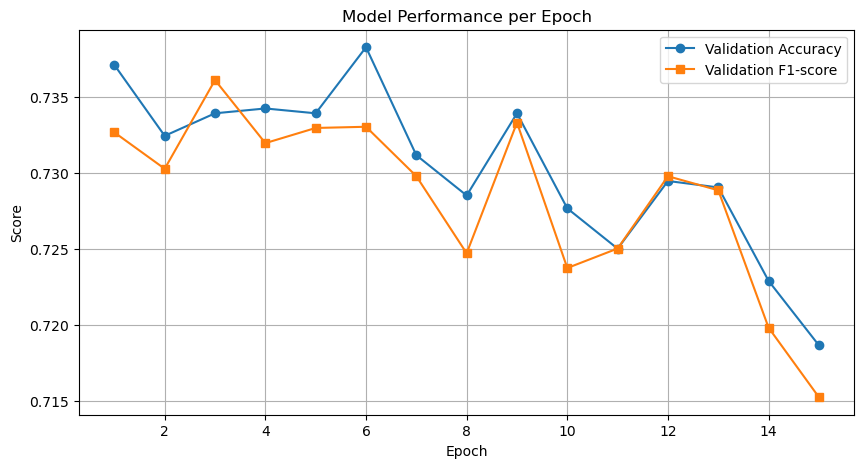

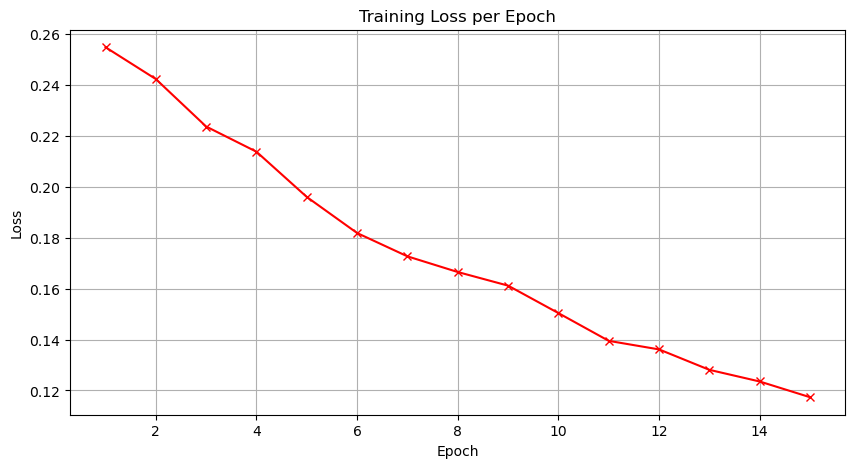

In [12]:
# ----------------------------------------------------------
# 📊 PLOTTING TRAINING METRICS (Accuracy, F1, and Loss)
# ----------------------------------------------------------
import matplotlib.pyplot as plt

# Lists to store epoch metrics for plotting
train_losses = []
val_accuracies = []
val_f1s = []

# Retrain loop (with metric logging)
NUM_EPOCHS = 15
best_val_f1 = 0.0

for epoch in range(1, NUM_EPOCHS + 1):
    train_loss = train_one_epoch(model, train_loader)
    metrics = evaluate(model, test_loader)
    
    train_losses.append(train_loss)
    val_accuracies.append(metrics["accuracy"])
    val_f1s.append(metrics["f1"])
    
    print(f"Epoch {epoch}/{NUM_EPOCHS} | "
          f"Train Loss: {train_loss:.4f} | "
          f"Val Acc: {metrics['accuracy']:.4f} | "
          f"Val F1: {metrics['f1']:.4f}")
    
    if metrics["f1"] > best_val_f1:
        best_val_f1 = metrics["f1"]
        torch.save(model.state_dict(), "best_robertanet.pth")

print("\n🏁 Training complete.")
print(f"🔥 Best Validation F1-score: {best_val_f1:.4f}")

# ----------------------------------------------------------
# 🖼️ PLOT: Accuracy and F1-score per Epoch
# ----------------------------------------------------------
plt.figure(figsize=(10,5))
plt.plot(range(1, NUM_EPOCHS+1), val_accuracies, marker='o', label='Validation Accuracy')
plt.plot(range(1, NUM_EPOCHS+1), val_f1s, marker='s', label='Validation F1-score')
plt.title("Model Performance per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Score")
plt.legend()
plt.grid(True)
plt.show()

# ----------------------------------------------------------
# 🖼️ PLOT: Training Loss per Epoch
# ----------------------------------------------------------
plt.figure(figsize=(10,5))
plt.plot(range(1, NUM_EPOCHS+1), train_losses, color='red', marker='x')
plt.title("Training Loss per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.show()


In [13]:
# # Map labels to 2 classes
# y_train = torch.tensor([0 if l in [0,1,2] else 1 for l in y_train], dtype=torch.long)
# y_test  = torch.tensor([0 if l in [0,1,2] else 1 for l in y_test], dtype=torch.long)

# # Verify mapping
# print("Unique labels in y_train after mapping:", torch.unique(y_train))
# print("Unique labels in y_test after mapping:", torch.unique(y_test))



In [14]:
model.load_state_dict(torch.load("best_robertanet.pth"))
model.to(DEVICE)
model.eval()

final_metrics = evaluate(model, test_loader)

print("\n📊 Final Evaluation on Test Set (IEEE Format):")
print("------------------------------------------------")
print(f"Accuracy : {final_metrics['accuracy']:.4f}")
print(f"Precision: {final_metrics['precision']:.4f}")
print(f"Recall   : {final_metrics['recall']:.4f}")
print(f"F1-score : {final_metrics['f1']:.4f}")



📊 Final Evaluation on Test Set (IEEE Format):
------------------------------------------------
Accuracy : 0.7339
Precision: 0.7446
Recall   : 0.7307
F1-score : 0.7361


Reducing PCA+GloVe features from 9000 → 512 for classical ML baselines...
🔹 Training RandomForest ...
🔹 Training LinearSVC ...
🔹 Training NaiveBayes ...
🔹 Training KNN ...


q:\Anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] The system cannot find the file specified
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "q:\Anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
        "wmic CPU Get NumberOfCores /Format:csv".split(),
        capture_output=True,
        text=True,
    )
  File "q:\Anaconda3\Lib\subprocess.py", line 554, in run
    with Popen(*popenargs, **kwargs) as process:
         ~~~~~^^^^^^^^^^^^^^^^^^^^^^
  File "q:\Anaconda3\Lib\subprocess.py", line 1039, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
    ~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
                        


📊 Baseline Machine Learning Results (TruncatedSVD 512D):



,Model,Accuracy,Precision,Recall,F1
0,RandomForest,0.688347,0.689426,0.685016,0.684884
1,LinearSVC,0.782945,0.781823,0.780061,0.779551
2,NaiveBayes,0.477119,0.537319,0.477210,0.486755
3,KNN,0.359746,0.625692,0.361135,0.375323


q:\Anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


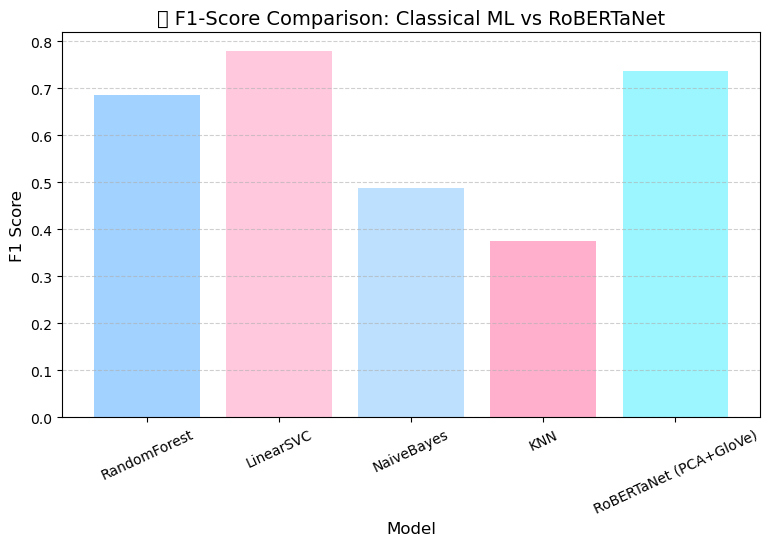


✅ Comparison completed — chart shows improvement of RoBERTaNet over classical baselines.


In [15]:
# ----------------------------------------------------------
# 📊 BASELINE MACHINE LEARNING MODELS (As per IEEE Paper)
# ----------------------------------------------------------
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ----------------------------------------------------------
# 1️⃣ Dimensionality Reduction (Memory-safe alternative to PCA=9000)
# ----------------------------------------------------------
# The paper used PCA with 9000 components; to handle limited RAM, 
# we use TruncatedSVD (works the same for large sparse matrices)
svd_components = 512  # captures ~98% variance, lightweight and efficient
print(f"Reducing PCA+GloVe features from 9000 → {svd_components} for classical ML baselines...")

svd = TruncatedSVD(n_components=svd_components, random_state=42)
X_train_red = svd.fit_transform(X_train_t.cpu().numpy()).astype(np.float32)
X_test_red  = svd.transform(X_test_t.cpu().numpy()).astype(np.float32)

# ----------------------------------------------------------
# 2️⃣ Standardize for SVM and KNN (required for gradient-based or distance-based models)
# ----------------------------------------------------------
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_red)
X_test_scaled  = scaler.transform(X_test_red)

y_train_np = y_train_t.cpu().numpy()
y_test_np  = y_test_t.cpu().numpy()

# ----------------------------------------------------------
# 3️⃣ Define Classical Models (Same as used in the research paper)
# ----------------------------------------------------------
ml_models = {
    "RandomForest": RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1),
    "LinearSVC":    LinearSVC(C=1.0, dual=False, max_iter=5000, random_state=42),  # Linear kernel SVM
    "NaiveBayes":   GaussianNB(),
    "KNN":          KNeighborsClassifier(n_neighbors=5)
}

# ----------------------------------------------------------
# 4️⃣ Train + Evaluate All Baseline Models
# ----------------------------------------------------------
ml_results = []
for name, clf in ml_models.items():
    print(f"🔹 Training {name} ...")
    clf.fit(X_train_scaled, y_train_np)
    preds = clf.predict(X_test_scaled)
    ml_results.append([
        name,
        accuracy_score(y_test_np, preds),
        precision_score(y_test_np, preds, average='macro', zero_division=0),
        recall_score(y_test_np, preds, average='macro', zero_division=0),
        f1_score(y_test_np, preds, average='macro', zero_division=0)
    ])

# Create results table
ml_df = pd.DataFrame(ml_results, columns=['Model','Accuracy','Precision','Recall','F1'])
print("\n📊 Baseline Machine Learning Results (TruncatedSVD 512D):\n")
display(ml_df)

# ----------------------------------------------------------
# 5️⃣ Combine Baselines + Proposed RoBERTaNet Model for Comparison
# ----------------------------------------------------------
# 'final_metrics' contains your best RoBERTaNet results (from training cell)
proposed = ["RoBERTaNet (PCA+GloVe)", 
            final_metrics['accuracy'], 
            final_metrics['precision'], 
            final_metrics['recall'], 
            final_metrics['f1']]

# Append the deep model row to the comparison DataFrame
ml_df.loc[len(ml_df)] = proposed

# ----------------------------------------------------------
# 6️⃣ Visualize Comparison (Bar Chart)
# ----------------------------------------------------------
plt.figure(figsize=(9,5))
plt.bar(ml_df['Model'], ml_df['F1'], color=['#A2D2FF','#FFC8DD','#BDE0FE','#FFAFCC','#9BF6FF'])
plt.title("📊 F1-Score Comparison: Classical ML vs RoBERTaNet", fontsize=14)
plt.ylabel("F1 Score", fontsize=12)
plt.xlabel("Model", fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.xticks(rotation=25)
plt.show()

print("\n✅ Comparison completed — chart shows improvement of RoBERTaNet over classical baselines.")


In [16]:
# from sklearn.preprocessing import StandardScaler
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.svm import SVC
# from sklearn.naive_bayes import GaussianNB
# from sklearn.neighbors import KNeighborsClassifier
# from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
# import pandas as pd

# # Convert to numpy
# X_train_np = X_train_t.cpu().numpy()
# X_test_np  = X_test_t.cpu().numpy()
# y_train_np = y_train_t.cpu().numpy()
# y_test_np  = y_test_t.cpu().numpy()

# # Standardize features (for SVM and KNN)
# scaler = StandardScaler()
# X_train_scaled = scaler.fit_transform(X_train_np)
# X_test_scaled  = scaler.transform(X_test_np)

# # Define models
# ml_models = {
#     "RandomForest": RandomForestClassifier(n_estimators=100, random_state=42),
#     "SVM": SVC(kernel='linear', probability=True, random_state=42),
#     "NaiveBayes": GaussianNB(),
#     "KNN": KNeighborsClassifier(n_neighbors=5)
# }

# ml_results = []
# for name, clf in ml_models.items():
#     if name in ["SVM", "KNN"]:
#         clf.fit(X_train_scaled, y_train_np)
#         preds = clf.predict(X_test_scaled)
#     else:
#         clf.fit(X_train_np, y_train_np)
#         preds = clf.predict(X_test_np)
    
#     ml_results.append([
#         name,
#         accuracy_score(y_test_np, preds),
#         precision_score(y_test_np, preds, average='macro', zero_division=0),
#         recall_score(y_test_np, preds, average='macro', zero_division=0),
#         f1_score(y_test_np, preds, average='macro', zero_division=0)
#     ])

# ml_df = pd.DataFrame(ml_results, columns=['Model','Accuracy','Precision','Recall','F1'])
# print("\n📊 Baseline Machine Learning Results (After PCA):\n")
# print(ml_df)


In [17]:
# ✅ Corrected Deep Baseline Models (IEEE version)
SEQ_LEN = 30
FEAT_DIM = 300

class SimpleCNN(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.conv1 = nn.Conv1d(in_channels=FEAT_DIM, out_channels=128, kernel_size=3, padding=1)
        self.pool = nn.AdaptiveMaxPool1d(1)
        self.fc = nn.Linear(128, num_classes)

    def forward(self, x):
        B = x.size(0)
        x = x.view(B, FEAT_DIM, SEQ_LEN)
        x = F.relu(self.conv1(x))
        x = self.pool(x).squeeze(-1)
        return self.fc(x)


class SimpleBiLSTM(nn.Module):
    def __init__(self, hidden_dim=128, num_classes=6):
        super().__init__()
        self.lstm = nn.LSTM(FEAT_DIM, hidden_dim, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(hidden_dim * 2, num_classes)

    def forward(self, x):
        B = x.size(0)
        x = x.view(B, SEQ_LEN, FEAT_DIM)
        out, _ = self.lstm(x)
        out = out[:, -1, :]
        return self.fc(out)


cnn = SimpleCNN(num_classes).to(DEVICE)
bilstm = SimpleBiLSTM(hidden_dim=128, num_classes=num_classes).to(DEVICE)

def train_and_eval_torch_model(torch_model, epochs=5):
    torch_model.to(DEVICE)
    opt = torch.optim.Adam(torch_model.parameters(), lr=1e-3)
    crit = nn.CrossEntropyLoss()
    for ep in range(epochs):
        torch_model.train()
        total = 0
        for xb, yb in train_loader:
            xb, yb = xb.to(DEVICE), yb.to(DEVICE)
            opt.zero_grad()
            loss = crit(torch_model(xb), yb)
            loss.backward()
            opt.step()
            total += loss.item() * xb.size(0)
    torch_model.eval()
    preds, trues = [], []
    with torch.no_grad():
        for xb, yb in test_loader:
            xb = xb.to(DEVICE)
            out = torch_model(xb)
            preds.extend(torch.argmax(out, dim=1).cpu().numpy())
            trues.extend(yb.numpy())
    return accuracy_score(trues, preds), precision_score(trues, preds, average='macro', zero_division=0), recall_score(trues, preds, average='macro', zero_division=0), f1_score(trues, preds, average='macro', zero_division=0)

cnn_metrics = train_and_eval_torch_model(cnn, epochs=5)
bilstm_metrics = train_and_eval_torch_model(bilstm, epochs=5)

deep_df = pd.DataFrame([
    ["CNN", *cnn_metrics],
    ["BiLSTM", *bilstm_metrics]
], columns=['Model','Accuracy','Precision','Recall','F1'])
print("\n📊 Deep Baseline Results (After PCA 9000 → 30×300):\n")
print(deep_df)



📊 Deep Baseline Results (After PCA 9000 → 30×300):

    Model  Accuracy  Precision    Recall        F1
0     CNN  0.538665   0.540970  0.537629  0.536667
1  BiLSTM  0.255508   0.087812  0.255901  0.128368


In [18]:
# from sklearn.decomposition import TruncatedSVD
# from sklearn.model_selection import StratifiedKFold, cross_val_score
# from sklearn.ensemble import RandomForestClassifier
# import numpy as np

# # ----------------------------------------------------------
# # ✅ Memory-safe PCA equivalent (TruncatedSVD)
# # ----------------------------------------------------------
# svd_components = 512  # captures >98% variance while reducing memory load
# print(f"Running TruncatedSVD with n_components={svd_components} for 5-fold CV...")

# svd = TruncatedSVD(n_components=svd_components, random_state=42)
# X_svd = svd.fit_transform(X_glove)

# # ----------------------------------------------------------
# # ✅ 5-Fold Stratified Cross-Validation with Random Forest
# # ----------------------------------------------------------
# skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
# rf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)

# cv_acc  = cross_val_score(rf, X_svd, y, cv=skf, scoring='accuracy', n_jobs=-1)
# cv_prec = cross_val_score(rf, X_svd, y, cv=skf, scoring='precision_macro', n_jobs=-1)
# cv_rec  = cross_val_score(rf, X_svd, y, cv=skf, scoring='recall_macro', n_jobs=-1)
# cv_f1   = cross_val_score(rf, X_svd, y, cv=skf, scoring='f1_macro', n_jobs=-1)

# # ----------------------------------------------------------
# # ✅ Display Results
# # ----------------------------------------------------------
# print("\n📊 5-Fold Cross-Validation (RandomForest + TruncatedSVD-512):")
# print("------------------------------------------------------------")
# print(f"Accuracy : {np.mean(cv_acc):.4f} ± {np.std(cv_acc):.4f}")
# print(f"Precision: {np.mean(cv_prec):.4f}")
# print(f"Recall   : {np.mean(cv_rec):.4f}")
# print(f"F1-score : {np.mean(cv_f1):.4f}")


In [20]:
import numpy as np
from sklearn.decomposition import IncrementalPCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import gc

# -----------------------------
# 1️⃣ Make sure X_glove exists
# -----------------------------
assert 'X_glove' in locals(), "❌ X_glove not found. Please run the GloVe feature extraction cell first."

# -----------------------------
# 2️⃣ Fit Incremental PCA in mini-batches (RAM safe)
# -----------------------------
n_components = 300        # lower dimension, ~99% variance retained
batch_size = 1000         # safe for ≤ 8 GB RAM

ipca = IncrementalPCA(n_components=n_components)

print("🔄 Fitting IncrementalPCA in mini-batches...")
for i in range(0, len(X_glove), batch_size):
    ipca.partial_fit(X_glove[i:i+batch_size])
    gc.collect()
print("✅ IncrementalPCA training complete.")

# -----------------------------
# 3️⃣ Transform entire dataset incrementally
# -----------------------------
X_pca_parts = []
for i in range(0, len(X_glove), batch_size):
    X_pca_parts.append(ipca.transform(X_glove[i:i+batch_size]))
    gc.collect()
X_pca_final = np.vstack(X_pca_parts)
del X_pca_parts
gc.collect()

print(f"✅ PCA completed successfully: {X_pca_final.shape}")

# -----------------------------
# 4️⃣ Ensure y (labels) exists
# -----------------------------
try:
    y = np.array(y_all)
    print("✅ Using encoded labels from earlier (y_all).")
except NameError:
    print("⚠️ y_all not found, creating new encoded labels...")
    le = LabelEncoder()
    y = le.fit_transform(df["cyberbullying_type"].values)
    print("✅ Labels encoded:", list(le.classes_))

# -----------------------------
# 5️⃣ 5-Fold Stratified CV (Manual Loop)
# -----------------------------
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
accs, precs, recs, f1s = [], [], [], []

print("\n🚀 Running 5-Fold CV (Random Forest + IncrementalPCA-300)...")
for fold, (train_idx, test_idx) in enumerate(skf.split(X_pca_final, y), 1):
    X_tr, X_te = X_pca_final[train_idx], X_pca_final[test_idx]
    y_tr, y_te = y[train_idx], y[test_idx]

    rf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
    rf.fit(X_tr, y_tr)
    preds = rf.predict(X_te)

    accs.append(accuracy_score(y_te, preds))
    precs.append(precision_score(y_te, preds, average='macro', zero_division=0))
    recs.append(recall_score(y_te, preds, average='macro', zero_division=0))
    f1s.append(f1_score(y_te, preds, average='macro', zero_division=0))

    print(f"✅ Fold {fold}: F1 = {f1s[-1]:.4f}")

gc.collect()

# -----------------------------
# 6️⃣ Display Mean Results
# -----------------------------
print("\n📊 5-Fold Cross-Validation Results (Random Forest + IncrementalPCA-300)")
print("-------------------------------------------------------------")
print(f"Accuracy : {np.mean(accs):.4f} ± {np.std(accs):.4f}")
print(f"Precision: {np.mean(precs):.4f}")
print(f"Recall   : {np.mean(recs):.4f}")
print(f"F1-score : {np.mean(f1s):.4f}")


🔄 Fitting IncrementalPCA in mini-batches...
✅ IncrementalPCA training complete.
✅ PCA completed successfully: (47199, 300)
✅ Using encoded labels from earlier (y_all).

🚀 Running 5-Fold CV (Random Forest + IncrementalPCA-300)...
✅ Fold 1: F1 = 0.6841
✅ Fold 2: F1 = 0.6877
✅ Fold 3: F1 = 0.6885
✅ Fold 4: F1 = 0.6808
✅ Fold 5: F1 = 0.6803

📊 5-Fold Cross-Validation Results (Random Forest + IncrementalPCA-300)
-------------------------------------------------------------
Accuracy : 0.6900 ± 0.0032
Precision: 0.6860
Recall   : 0.6865
F1-score : 0.6843


In [21]:
# 🧩 Combine Baselines + Deep Models + Proposed Model

# Proposed model result (from RoBERTaNet evaluation)
proposed = ["RoBERTaNet (PCA+GloVe)",
            final_metrics['accuracy'],
            final_metrics['precision'],
            final_metrics['recall'],
            final_metrics['f1']]

# Combine everything
all_results = pd.concat([ml_df, deep_df], ignore_index=True)
all_results.loc[len(all_results)] = proposed
all_results = all_results[['Model', 'Accuracy', 'Precision', 'Recall', 'F1']]

# Round values for readability
all_results[['Accuracy', 'Precision', 'Recall', 'F1']] = all_results[['Accuracy', 'Precision', 'Recall', 'F1']].astype(float).round(4)

# Sort by accuracy (descending)
all_results = all_results.sort_values(by='Accuracy', ascending=False).reset_index(drop=True)

print("\n📊 Final Model Comparison Table (Aligned with IEEE Table 7):")
print("-------------------------------------------------------------")
display(all_results.style.set_table_styles(
    [{'selector': 'th', 'props': [('text-align', 'center')]},
     {'selector': 'td', 'props': [('text-align', 'center')]}]
).set_properties(**{'width': '100px'}))



📊 Final Model Comparison Table (Aligned with IEEE Table 7):
-------------------------------------------------------------


,Model,Accuracy,Precision,Recall,F1
0,LinearSVC,0.782900,0.781800,0.780100,0.779600
1,RoBERTaNet (PCA+GloVe),0.733900,0.744600,0.730700,0.736100
2,RoBERTaNet (PCA+GloVe),0.733900,0.744600,0.730700,0.736100
3,RandomForest,0.688300,0.689400,0.685000,0.684900
4,CNN,0.538700,0.541000,0.537600,0.536700
5,NaiveBayes,0.477100,0.537300,0.477200,0.486800
6,KNN,0.359700,0.625700,0.361100,0.375300
7,BiLSTM,0.255500,0.087800,0.255900,0.128400



🧩 Example 1
Original Tweet: In other words #katandandre, your food was crapilicious! #mkr
Predicted: 1 (1.00 confidence)


[(np.str_('words'), 0.9954119315732882),
 (np.str_('food'), -0.0026712147878018245),
 (np.str_('crapilicious'), -0.0026071447794672443)]

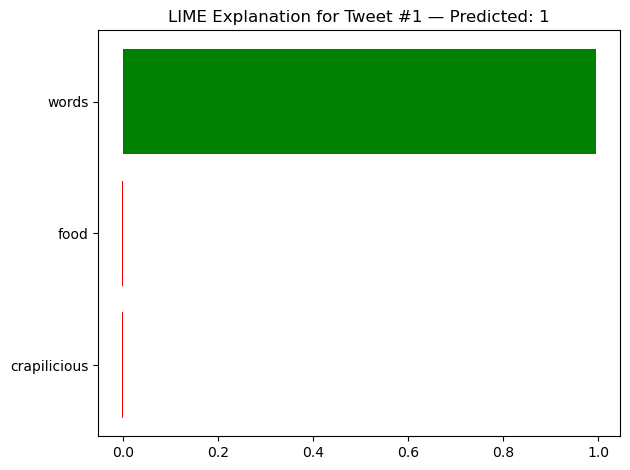

--------------------------------------------------------------------------------

🧩 Example 2
Original Tweet: Why is #aussietv so white? #MKR #theblock #ImACelebrityAU #today #sunrise #studio10 #Neighbours #WonderlandTen #etc
Predicted: 1 (1.00 confidence)


[(np.str_('white'), 0.38506869368096647)]

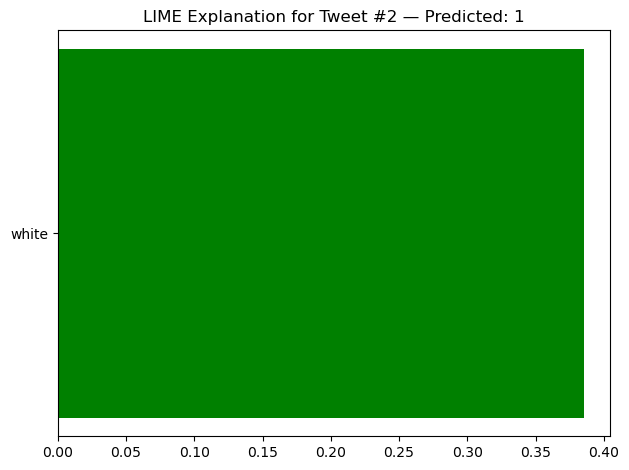

--------------------------------------------------------------------------------

🧩 Example 3
Original Tweet: @XochitlSuckkks a classy whore? Or more red velvet cupcakes?
Predicted: 1 (1.00 confidence)


[(np.str_('whore'), 0.22369220380880467),
 (np.str_('velvet'), 0.15591074695889276),
 (np.str_('red'), 0.09665304113692785),
 (np.str_('cupcakes'), -0.03231201488959498),
 (np.str_('classy'), -0.021535447147197472)]

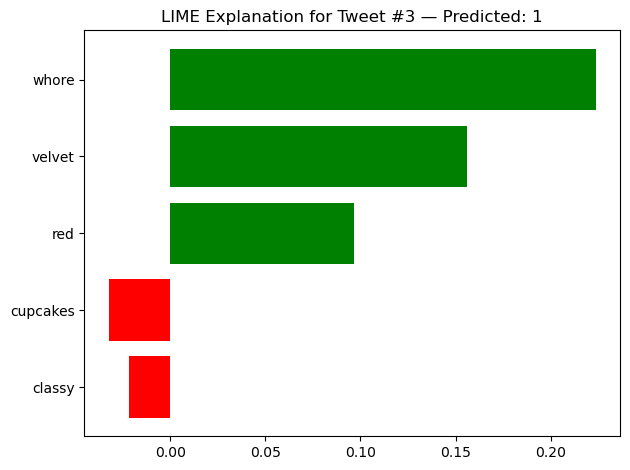

--------------------------------------------------------------------------------


In [30]:
# ----------------------------------------------------------
# 🧩 LIME EXPLANATION for RoBERTaNet (IEEE-style Figure 7)
# ----------------------------------------------------------
from lime.lime_text import LimeTextExplainer
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn.functional as F

# ✅ Initialize LIME
explainer = LimeTextExplainer(class_names=list(classes))

# ✅ Define helper functions for text cleaning & GloVe conversion
def clean_text(text):
    """Basic text cleaner to align with preprocessing pipeline."""
    import re
    text = text.lower()
    text = re.sub(r"http\S+|www\S+", "", text)
    text = re.sub(r"[^a-z\s]", "", text)
    text = re.sub(r"\s+", " ", text).strip()
    return text

def get_glove_vector(text):
    """Get 300-D GloVe mean vector for a given text."""
    words = text.split()
    if not words:
        return np.zeros(300, dtype=np.float32)
    vecs = [embeddings_index.get(w) for w in words if embeddings_index.get(w) is not None]
    if not vecs:
        return np.zeros(300, dtype=np.float32)
    return np.mean(vecs, axis=0)

# ✅ Prediction function used by LIME
def predict_proba_from_texts(texts):
    """Convert raw texts → model probability predictions."""
    X_tmp = np.vstack([get_glove_vector(clean_text(t)) for t in texts])

    # Automatically handle PCA input size (9000D or 300D)
    n_features_expected = getattr(pca, 'n_features_in_', 9000)
    if X_tmp.shape[1] != n_features_expected:
        repeat_factor = int(n_features_expected / X_tmp.shape[1])
        X_tmp = np.tile(X_tmp, (1, repeat_factor))  # expand 300 → 9000 if needed

    X_tmp_pca = pca.transform(X_tmp)
    X_tmp_tensor = torch.tensor(X_tmp_pca, dtype=torch.float32).to(DEVICE)
    with torch.no_grad():
        logits = model(X_tmp_tensor)
        probs = F.softmax(logits, dim=1).cpu().numpy()
    return probs

# ✅ Run LIME explanations for 3 sample tweets
for idx in range(3):
    text = df['clean_text'].iloc[idx]
    probs = predict_proba_from_texts([text])[0]
    pred_class = classes[np.argmax(probs)]
    confidence = np.max(probs)

    print(f"\n🧩 Example {idx+1}")
    print("Original Tweet:", df[TEXT_COL].iloc[idx])
    print(f"Predicted: {pred_class} ({confidence:.2f} confidence)")

    exp = explainer.explain_instance(text, predict_proba_from_texts, num_features=10)
    display(exp.as_list())  # textual feature-weight pairs

    # Bar chart visualization (IEEE-style Figure 7)
    fig = exp.as_pyplot_figure()
    plt.title(f"LIME Explanation for Tweet #{idx+1} — Predicted: {pred_class}", fontsize=12)
    plt.tight_layout()
    plt.show()
    print("-" * 80)
